<a href="https://colab.research.google.com/github/raulbenitez/NEUROIMAGING_AI/blob/main/Classification/pattern_recognition_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Recognition in digital images

This notebook will guide you through three different approaches do recognize patterns in digital images:

1. Object recognition using regional properties: We first segment the objects, extract some attributes (shape, size, etc) and train a classifier that recognizes the different types of objects. 

2. Face recognition using PCA features: USe PCA in order to extract meaningful features that allow classifying images to recognize faces.

3. Deep learning: Feature extraction is performed using a convolutional neural network. The classification can be either integrated in a artificial neural network architecture or used in another supervised classifier. 

## 1. Object recognition using regional properties:

Let's start with an image with circles and triangles of different sizes:

### 1. Generation of the sample image:

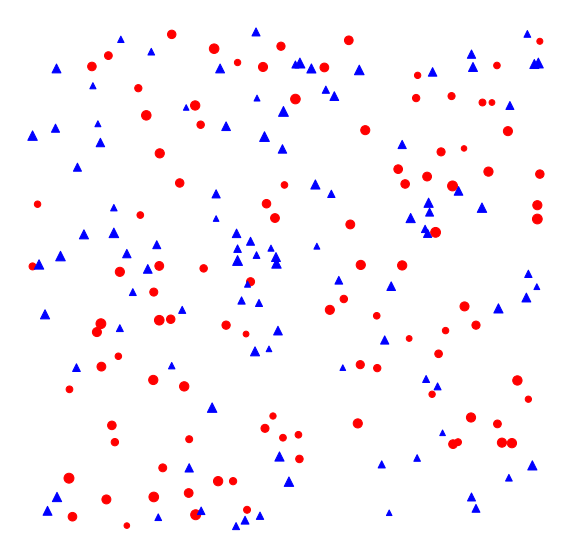

In [2]:
import numpy as np 
np.random.seed(13)

import matplotlib.pyplot as plt 
Isize = 1024
N = 100

X = np.random.randint(Isize, size=(2,2*N)) # random placement of objects

fig = plt.figure(figsize=(10,10))
symsizes1 = np.random.randint(30,100,size=(1,N))
symsizes2 = np.random.randint(30,100,size=(1,N))
plt.scatter(X[0,0:N], X[1,0:N], s=symsizes1, c='r',edgecolor="red",marker = 'o')
plt.scatter(X[0,N:2*N], X[1,N:2*N], s=symsizes2, c='b',edgecolor="blue",marker = '^')
plt.axis('off')
plt.savefig('Patterns.png',dpi=600, facecolor='w',optimize=False,bbox_inches='tight')
plt.show()

### Reading the image:

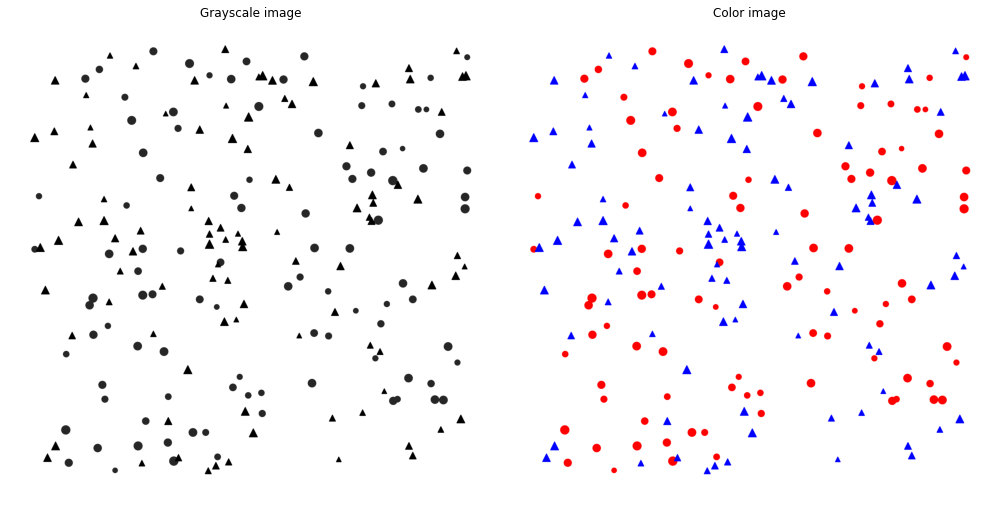

In [3]:
import matplotlib.pyplot as plt
from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label

I = io.imread('Patterns.png',as_gray=True) # read image as grayscale (no color information)
IC = io.imread('Patterns.png') # read image as color (to define object class labels: triangle, circle)

fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(I,cmap=plt.cm.gray)
ax[0].set_title('Grayscale image') 
ax[1].imshow(IC,cmap=plt.cm.jet)
ax[1].set_title('Color image') # set figure title

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

### 2. Segmentation and regional features:

We now segment and extract regional properties:

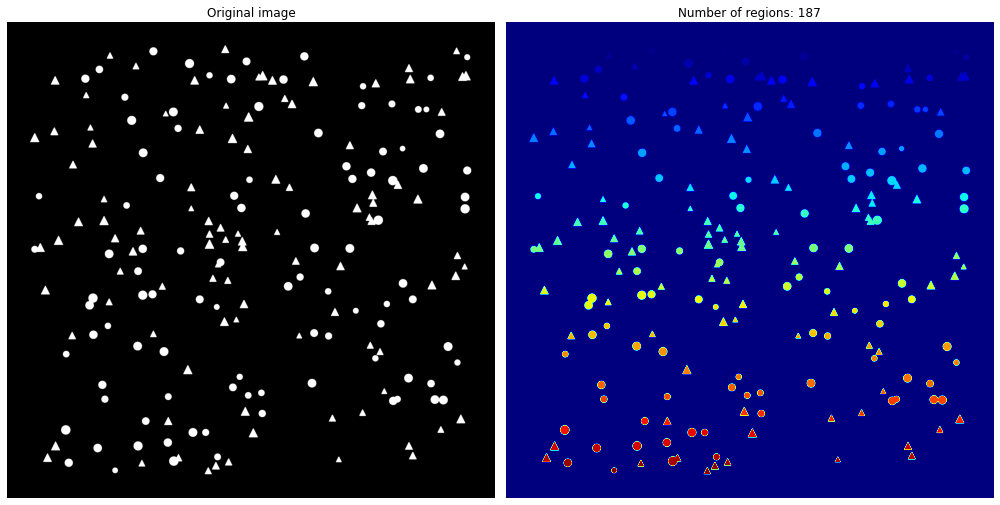

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [15]:
bw = np.logical_not(I==1)# Set regions white and background black
# label image regions:
label_image, nregions = label(bw,return_num=True)

# Segmentation figure:
fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(bw,cmap=plt.cm.gray)
ax[0].set_title('Original image') 
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

# Get regional properties:
from skimage.measure import regionprops
props = regionprops(label_image)

# Get relevant features (eccentricity and area, for instance)
features = np.zeros((nregions,3))
labels = np.zeros(nregions)
# Save class label of each object (1: triangle, 2:circle)
bw1 = np.array(IC[:,:,0]==0,dtype=np.uint8)
bw2 = np.array(IC[:,:,2]==0,dtype=np.uint8)
for i in range(0,nregions):
    features[i,0] = props[i].eccentricity
    features[i,1] = props[i].area
    features[i,2] = props[i].solidity

    labels[i] = bw1[np.int(props[i].centroid[0]),np.int(props[i].centroid[1])]+2*bw2[np.int(props[i].centroid[0]),np.int(props[i].centroid[1])]

### 3. Exploratory analysis of features:

A scatterplot of features shows that circles present low eccentricity whereas triangles present eccentricity around 0.5. There are some observations with higher eccentricities due to the overlaping cases between triangles and circles. 

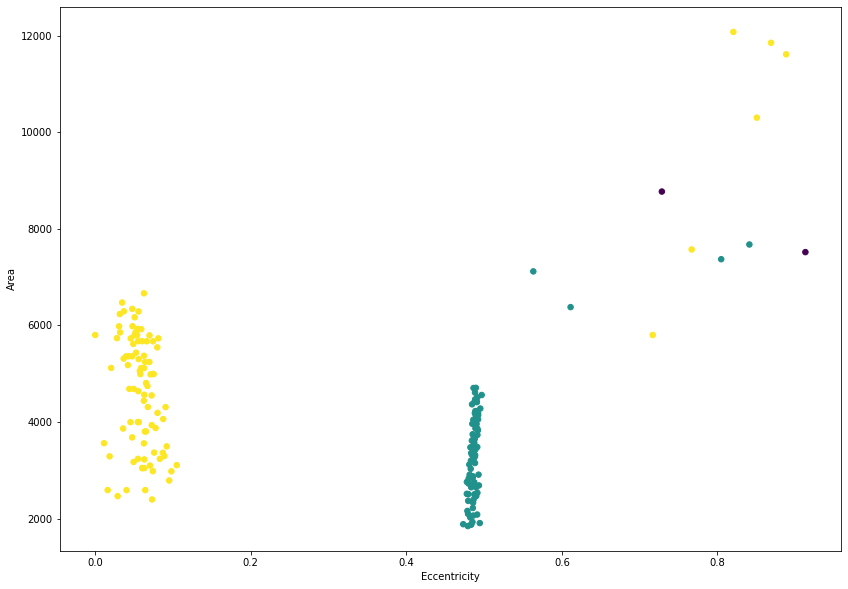

In [22]:
fig = plt.figure(figsize=(14,10))
plt.scatter(features[:,0], features[:,1], s=30, c=labels,marker = 'o')
plt.xlabel('Eccentricity')
plt.ylabel('Area')
plt.show()

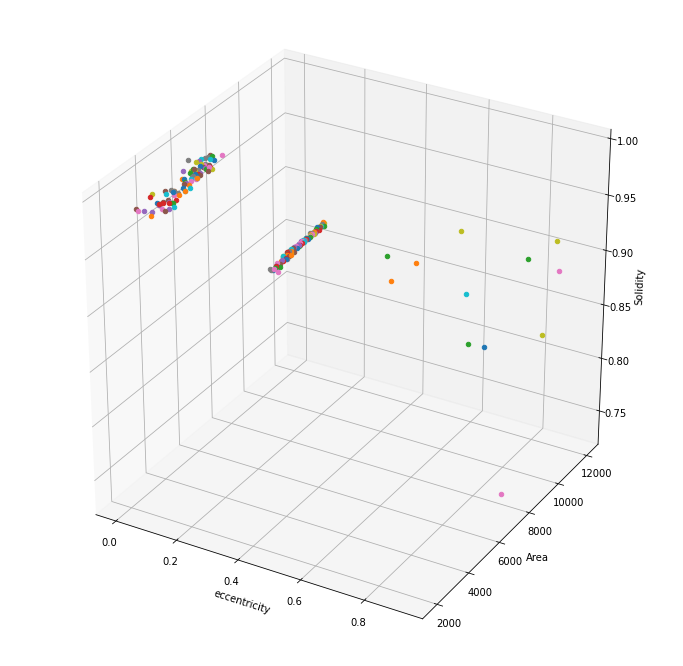

In [20]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')


# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
for k in range(features.shape[0]):
    xs = features[k,0]
    ys = features[k,1]
    zs = features[k,2]
    ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('eccentricity')
ax.set_ylabel('Area')
ax.set_zlabel('Solidity')

plt.show()

In [6]:
features.shape

(187, 2)

In [9]:
np.unique(labels)

array([0., 1., 2.])

### 4. Fit Linear Discriminant Analysis (LDA):

Using object features (eccentricity, area) and object class (triangle, circle): Train classifier with the first NTRAIN observations. Fit a LDA classifier using object features (eccentricity, area) and object class (triangle, circle): Train classifier with the first NTRAIN observations:

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

NTRAIN = 50 # Train with NTRAIN objects

clf = LinearDiscriminantAnalysis()
clf.fit(features[0:NTRAIN,:], labels[0:NTRAIN])

LinearDiscriminantAnalysis()

Evaluate performance using Test dataset:

In [24]:
labels_pred = clf.predict(features[NTRAIN+1:-1])
labels_true = labels[NTRAIN+1:-1]

In [25]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(labels_true,labels_pred)
CM

array([[ 0,  2,  0],
       [ 0, 62,  0],
       [ 0,  6, 65]])

In [26]:
from sklearn.metrics import classification_report
print(classification_report(labels_true,labels_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.89      1.00      0.94        62
         2.0       1.00      0.92      0.96        71

    accuracy                           0.94       135
   macro avg       0.63      0.64      0.63       135
weighted avg       0.93      0.94      0.93       135



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. Face recognition using PCA features:

We need a labelled face recognition database in which each image has a class label identifying the person to which it corresponds. In this case we are not classifying objects (regions of the image) but the whole image itself. We are going to use the Principal Component Analysis (PCA) of the pixels in the image as features of the whole image instead regional properties as in the previous example. PCA is a dimensionality reduction method that reduces the number of variables needed to describe the images (before PCA, we use as many variables as pixels in the image, after PCA we have a reduced number of variables that are a weighted linear combination of the original pixels in the image). 

Let's get started: 

### 1. Read images from dataset:

In this example we are going to use the image dataset 'Labelled Faces in the Wild' http://vis-www.cs.umass.edu/lfw/
that contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured (famous people).

In [27]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=1)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print('Width {} pixels'.format(w))
print('Height {} pixels'.format(h))

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

2022-05-04 16:15:53,163 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012


Automatically created module for IPython interactive environment


2022-05-04 16:15:54,036 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2022-05-04 16:15:54,872 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2022-05-04 16:15:55,865 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 1288
n_features: 11750
n_classes: 7
Width 94 pixels
Height 125 pixels


In [28]:
X.shape

(1288, 11750)

### 2. Feature Extraction: PCA features (eigenfaces)

In [47]:
from sklearn.decomposition import PCA

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)


eigenfaces = pca.components_.reshape((n_components, h, w))

print("PCA projection of the images")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Extracting the top 150 eigenfaces from 966 faces
PCA projection of the images


In [50]:
pca.explained_variance_ratio_.cumsum()

array([0.1784078 , 0.318031  , 0.38397163, 0.43949863, 0.48777753,
       0.51562375, 0.53970987, 0.56100446, 0.5802014 , 0.59847623,
       0.61459726, 0.6298233 , 0.64181983, 0.6522563 , 0.66261697,
       0.6720879 , 0.6808073 , 0.6891284 , 0.69728017, 0.70465267,
       0.711579  , 0.71798587, 0.7243489 , 0.72998667, 0.73529154,
       0.74050725, 0.7455549 , 0.75045085, 0.75490725, 0.7591396 ,
       0.763198  , 0.7671407 , 0.7707873 , 0.77437246, 0.7778607 ,
       0.78125596, 0.78453755, 0.7876447 , 0.79065776, 0.7936107 ,
       0.7964936 , 0.79928464, 0.8019989 , 0.8047036 , 0.8072617 ,
       0.8097997 , 0.8122954 , 0.8146419 , 0.8169255 , 0.81917596,
       0.82139546, 0.823574  , 0.82573414, 0.8278488 , 0.82991534,
       0.8319261 , 0.8339199 , 0.8358458 , 0.83774865, 0.83961856,
       0.8414534 , 0.84321815, 0.8449416 , 0.84664077, 0.8483198 ,
       0.849926  , 0.8515126 , 0.8530872 , 0.85464734, 0.8561775 ,
       0.85769933, 0.8591764 , 0.8606472 , 0.8620668 , 0.86346

In [57]:
np.where(pca.explained_variance_ratio_.cumsum()>0.9)

array([108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149])

### 3. Fit different unsupervised classifiers:

### Support Vector Machine (SVM):

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print("Fitting the classifier to the training set")
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
svm = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
svm = svm.fit(X_train_pca, y_train)

Fitting the classifier to the training set


Performance Evaluation (using test images):

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Predicting people's names on the test set")
y_pred_svm = svm.predict(X_test_pca)
print(classification_report(y_test, y_pred_svm, target_names=target_names))
print(confusion_matrix(y_test, y_pred_svm, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.00      0.00      0.00        13
     Colin Powell       0.00      0.00      0.00        60
  Donald Rumsfeld       0.00      0.00      0.00        27
    George W Bush       0.45      1.00      0.62       146
Gerhard Schroeder       0.00      0.00      0.00        25
      Hugo Chavez       0.00      0.00      0.00        15
       Tony Blair       0.00      0.00      0.00        36

         accuracy                           0.45       322
        macro avg       0.06      0.14      0.09       322
     weighted avg       0.21      0.45      0.28       322

[[  0   0   0  13   0   0   0]
 [  0   0   0  60   0   0   0]
 [  0   0   0  27   0   0   0]
 [  0   0   0 146   0   0   0]
 [  0   0   0  25   0   0   0]
 [  0   0   0  15   0   0   0]
 [  0   0   0  36   0   0   0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Linear Discriminant Analysis (LDA):

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_pca, y_train)
y_pred_lda = lda.predict(X_test_pca)
print(classification_report(y_test, y_pred_lda, target_names=target_names))
print(confusion_matrix(y_test, y_pred_lda, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.69      0.75        13
     Colin Powell       0.79      0.90      0.84        60
  Donald Rumsfeld       0.74      0.74      0.74        27
    George W Bush       0.92      0.92      0.92       146
Gerhard Schroeder       0.81      0.84      0.82        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.82      0.78      0.80        36

         accuracy                           0.86       322
        macro avg       0.83      0.78      0.80       322
     weighted avg       0.86      0.86      0.86       322

[[  9   2   2   0   0   0   0]
 [  1  54   1   2   0   1   1]
 [  1   2  20   3   0   0   1]
 [  0   6   3 135   1   0   1]
 [  0   1   0   2  21   0   1]
 [  0   1   0   2   1   9   2]
 [  0   2   1   2   3   0  28]]


### Decision Trees:

In [34]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt = dt.fit(X_train_pca, y_train)
y_pred_dt = dt.predict(X_test_pca)
print(classification_report(y_test, y_pred_dt, target_names=target_names))
print(confusion_matrix(y_test, y_pred_dt, labels=range(n_classes)))


                   precision    recall  f1-score   support

     Ariel Sharon       0.11      0.15      0.13        13
     Colin Powell       0.42      0.42      0.42        60
  Donald Rumsfeld       0.12      0.19      0.15        27
    George W Bush       0.68      0.56      0.61       146
Gerhard Schroeder       0.20      0.20      0.20        25
      Hugo Chavez       0.11      0.13      0.12        15
       Tony Blair       0.15      0.17      0.16        36

         accuracy                           0.39       322
        macro avg       0.26      0.26      0.26       322
     weighted avg       0.44      0.39      0.41       322

[[ 2  2  3  3  2  0  1]
 [ 5 25  3 16  1  1  9]
 [ 2  5  5  7  4  1  3]
 [ 7 12 20 82  4  7 14]
 [ 1  3  6  3  5  5  2]
 [ 0  5  0  3  1  2  4]
 [ 1  8  4  7  8  2  6]]


### Artificial Neural Networks (ANNs):

In [35]:
from sklearn.neural_network import MLPClassifier
ann = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50,), random_state=1)
ann.fit(X_train_pca, y_train)
y_pred_ann = ann.predict(X_test_pca)
print(classification_report(y_test, y_pred_ann, target_names=target_names))
print(confusion_matrix(y_test, y_pred_ann, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.46      0.57        13
     Colin Powell       0.78      0.85      0.82        60
  Donald Rumsfeld       0.63      0.81      0.71        27
    George W Bush       0.90      0.84      0.87       146
Gerhard Schroeder       0.69      0.72      0.71        25
      Hugo Chavez       0.56      0.60      0.58        15
       Tony Blair       0.78      0.78      0.78        36

         accuracy                           0.80       322
        macro avg       0.73      0.72      0.72       322
     weighted avg       0.81      0.80      0.80       322

[[  6   2   3   2   0   0   0]
 [  1  51   2   3   0   1   2]
 [  0   2  22   2   0   0   1]
 [  0   5   6 123   5   4   3]
 [  0   2   0   2  18   2   1]
 [  1   2   0   0   2   9   1]
 [  0   1   2   4   1   0  28]]


## Deep Learning: Convolutional Neural Networks

We are going to use the image database for handwritten digits MNIST: http://yann.lecun.com/exdb/mnist/

The database has a training set of 60,000 images of digits, and a test set of 10,000 examples.

In Deep Learning, both feature extraction and classification are performed using a simple custom-made CNN architecture trained with the MNIST training subset. 
MNIST classification using a simple CNN architecture 

Load MNIST data

In [58]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Load data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Build and train

In [59]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [60]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

label_names = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

In [62]:
y_train_cat

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [63]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [64]:
batch_size =256
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/5
211/211 [==============================] - 40s 187ms/step - loss: 0.5037 - accuracy: 0.8488 - val_loss: 0.0990 - val_accuracy: 0.9730
Epoch 2/5
211/211 [==============================] - 40s 189ms/step - loss: 0.1374 - accuracy: 0.9575 - val_loss: 0.0665 - val_accuracy: 0.9822
Epoch 3/5
211/211 [==============================] - 51s 241ms/step - loss: 0.1019 - accuracy: 0.9688 - val_loss: 0.0543 - val_accuracy: 0.9868
Epoch 4/5
211/211 [==============================] - 37s 175ms/step - loss: 0.0831 - accuracy: 0.9743 - val_loss: 0.0461 - val_accuracy: 0.9875
Epoch 5/5
211/211 [==============================] - 37s 176ms/step - loss: 0.0714 - accuracy: 0.9776 - val_loss: 0.0411 - val_accuracy: 0.9893


### Evaluate 

In [65]:
score = model.evaluate(x_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(x_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.04081559181213379
Test accuracy: 0.9868999719619751
              precision    recall  f1-score   support

        zero       0.99      0.99      0.99       980
         one       0.99      1.00      0.99      1135
         two       0.98      0.99      0.99      1032
       three       0.99      0.98      0.99      1010
        four       0.99      0.99      0.99       982
        five       0.98      0.99      0.99       892
         six       1.00      0.98      0.99       958
       seven       0.98      0.98      0.98      1028
       eight       0.98      0.99      0.98       974
        nine       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [67]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_test_pred_DL_full, labels=range(10)))

[[ 975    0    0    0    0    1    1    1    2    0]
 [   0 1133    1    1    0    0    0    0    0    0]
 [   1    3 1021    0    1    0    0    4    2    0]
 [   0    0    3  994    0    6    0    4    3    0]
 [   1    1    0    0  972    0    1    0    2    5]
 [   2    0    0    3    0  883    1    1    2    0]
 [   4    3    1    0    3    3  941    0    3    0]
 [   0    5   10    2    0    1    0 1005    3    2]
 [   4    0    2    0    1    1    0    2  961    3]
 [   1    5    0    2    5    3    0    5    4  984]]


MNIST is a solved problem

### Use the trained model for Feature Extraction

Create a new model from the trained one with the features as output 

In [68]:
from tensorflow.keras.models import Model


model_FE = Model(inputs=model.input, outputs=model.get_layer('features').output)
model_FE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 1600)              0     

### Visualize trained features using UMAP

In [69]:
df_test = model_FE.predict(x_test) # extract Deep trained features from text subset

In [70]:
!pip install umap-learn

     |████████████████████████████████| 88 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 46.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=808e2a7e4f197ae8f01c761d5412f8d95b56995b1269a58dbb3408604e6f8e4e
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=eca5f2d7fe8e384edbf6298fe2ca9c5009a00a1d1a09f2838924fb2b8a949ed5
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [71]:
import umap
umap_df = umap.UMAP(n_neighbors=15).fit_transform(df_test.squeeze())

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


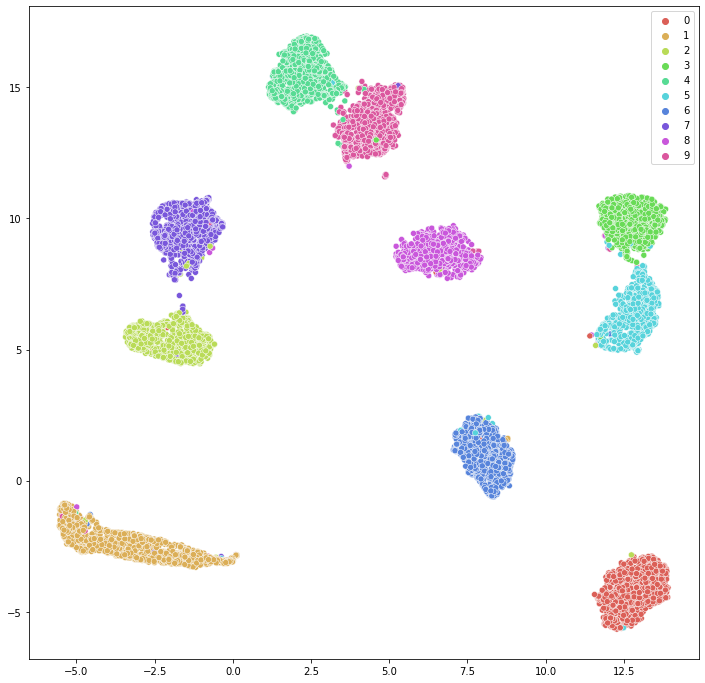

In [72]:
import seaborn as sns
fig = plt.figure(figsize=(12,12))
sns.scatterplot(x = umap_df[:,0], y = umap_df[:,1], hue = y_test, palette = sns.hls_palette(10), legend = 'full');

Everything looks much better with trained DL features than in any other scenario. Classifying with such features will provide a high accuracy.

### Classify trained features using KNN

In [73]:
from sklearn.neighbors import KNeighborsClassifier
import pickle 

# extract features from the training subset:
df_train = model_FE.predict(x_train)

knn_DL = KNeighborsClassifier(n_neighbors=2) # load the model
knn_DL.fit(df_train,y_train) # fit the model using training data
y_test_pred_DL = knn_DL.predict(df_test) # model prediction of test data  

              precision    recall  f1-score   support

        zero       0.98      1.00      0.99       980
         one       0.98      1.00      0.99      1135
         two       0.99      0.98      0.98      1032
       three       0.98      0.98      0.98      1010
        four       0.98      0.98      0.98       982
        five       0.99      0.98      0.98       892
         six       0.99      0.99      0.99       958
       seven       0.97      0.98      0.98      1028
       eight       0.99      0.97      0.98       974
        nine       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



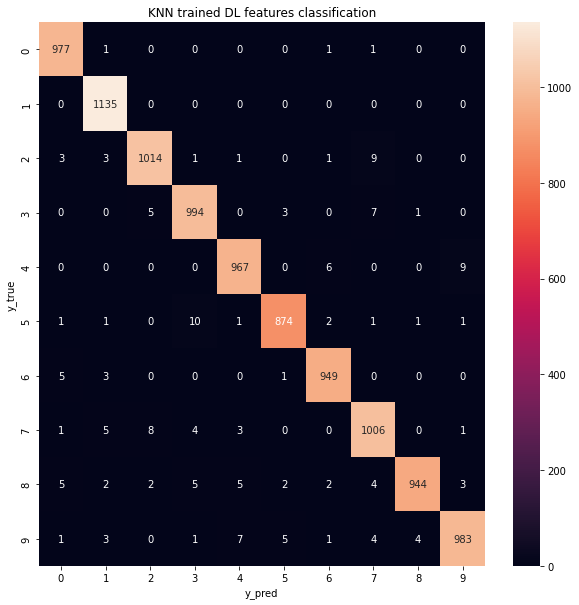

In [74]:
cm_DL = confusion_matrix(y_test, y_test_pred_DL)

fig = plt.figure(figsize=(10, 10))

sns.heatmap(cm_DL,annot = True,fmt = ".0f")
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.title('KNN trained DL features classification')

print(classification_report(y_test, y_test_pred_DL, target_names=label_names))